# The HFM library - A fast marching solver with adaptive stencils

## Part : Seismology and crystallography
## Chapter : Tilted transversally isotropic metrics

In this notebook, we demonstrate anisotropic fast marching with a class of metrics arising in seismic traveltime tomography. 
The intended use cases are fairly similar to [metrics defined by a Hooke tensor](Seismic.ipynb), which illustrates a closely related model. Under the hood, however, we use a completely different implementation.

**Tilted transversally isotropic models.**
We consider eikonal equations of the following form 
$$
    l(X^2+Y^2,Z^2) + q(X^2+Y^2,Z^2) = 1
$$
where $l$ is a linear form, and $q$ a quadratic form, and where 
$$
    (X,Y,Z) = A \nabla u
$$
for some linear transformation $A$. In dimension two, simply ignore the $Y$ coordinate.

Some algebraic conditions are required on $l$ and $q$ for this equation to make sense. On the other hand, the linear map $A$ is arbitrary.
In the special case where $q=0$, one recovers a Riemannian eikonal equation.

The numerical scheme is based on rewriting this equation as an extremum of a family of Riemannian eikonal equations, in the form
$$
    \max_{t \in [0,1]} \|\nabla u\|_{D(t)} = 1, 
$$
where $D(t)$ depends on the parameters $l$,$q$ and $A$, in addition to $t$. From this point, one can rely on the Eulerian discretization of [Riemannian eikonal equations](Riemannian.ipynb).

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Two dimensions](#1.-Two-dimensions)
    * [1.1 Induced norm](#1.1-Induced-norm)
    * [1.2 Fast marching method](#1.2-Fast-marching-method)
    * [1.3 Construction from Thomsen parameters, and comparison with a Hooke tensor norm](#1.3-Construction-from-Thomsen-parameters,-and-comparison-with-a-Hooke-tensor-norm)
    * [1.4 Taking into account the topography](#1.4-Taking-into-account-the-topography)
  * [2 Three dimensions](#2-Three-dimensions)
    * [2.1 Constant metric](#2.1-Constant-metric)
    * [2.2 Varying metric](#2.2-Varying-metric)
  * [3 Building a model from an array of Thomsen parameters](#3-Building-a-model-from-an-array-of-Thomsen-parameters)
    * [3.1 Hexagonal materials and Thomsen's parameter $\delta$](#3.1-Hexagonal-materials-and-Thomsen's-parameter-$\delta$)
    * [3.2 A numerical example, with the TTI eikonal solver](#3.2-A-numerical-example,-with-the-TTI-eikonal-solver)
    * [3.3 Using the Hooke eikonal solver](#3.3-Using-the-Hooke-eikonal-solver)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('TTI','FMM'))

In [2]:
from agd import Eikonal
from agd import LinearParallel as lp
from agd.Metrics import Seismic 
from agd import AutomaticDifferentiation as ad
from agd.Plotting import savefig; #savefig.dirName = 'Images/TTI'
norm_infinity = ad.Optimization.norm_infinity
mica = Seismic.TTI.mica[0]

In [3]:
import numpy as np; xp=np
#import scipy.linalg
#from copy import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,lp,Seismic
    Eikonal,ad,lp,Seismic = rreload([Eikonal,ad,lp,Seismic],rootdir="../..")

### 0.1 Optional configuration

In [5]:
#xp,plt,Eikonal,mica = map(ad.cupy_friendly,(xp,plt,Eikonal,mica))

## 1. Two dimensions

### 1.1 Induced norm

In [6]:
n=50
hfmIn = Eikonal.dictIn({
    'model':'TTI2',
    'exportValues':1,
    'seed':[0.,0.],
    'factoringRadius':-1, # Source factorization over the whole domain
    'order':2
})
w=1
hfmIn.SetRect(sides=[[-w,w],[-w,w]],dimx=2*n+1,sampleBoundary=True) # Define the domain
X = hfmIn.Grid() # Horizontal and vertical axis

The metric constructor takes as input the linear form $l$, and the quadratic form $q$, presented as a symmetric matrix (not necessarily positive definite).

In [7]:
metric = Seismic.TTI([1.,2.],[[0.,0.2],[0.2,0.]],vdim=2).rotate_by(0.5)
hfmIn['metric'] = metric

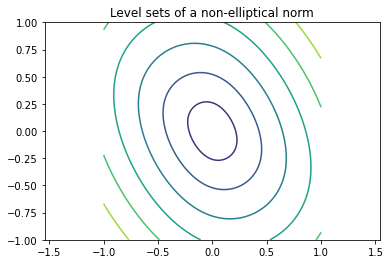

In [8]:
plt.title("Level sets of a non-elliptical norm"); plt.axis('equal')
plt.contour(*X,metric.norm(X));

As described in the introduction, the dual unit ball of a TTI norm is defined by a quartic equation.
We rely on a sequential quadratic programming approach to solve this equation, and check below that it is satisfied in the end.

In [9]:
v=xp.array((0.,1.))
grad = metric.gradient(v)
a=lp.transpose(lp.inverse(metric.inverse_transformation))
lvl = metric._dual_level(lp.dot_AV(a,grad))
print(f"v={v}, grad={grad}, lvl={lvl}")
assert np.abs(lvl)<1e-6

v=[0. 1.], grad=[0.24019447 0.76738101], lvl=-2.220446049250313e-16


### 1.2 Fast marching method

In [10]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.036386 s.


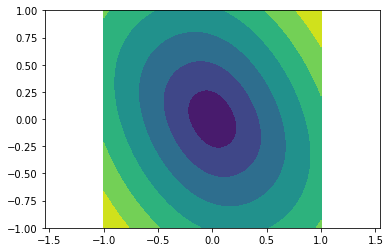

In [11]:
plt.axis('equal')
plt.contourf(*X,hfmOut['values']);

In [12]:
assert norm_infinity(hfmOut['values']-metric.norm(X)) < 0.01

In [13]:
#plt.axis('equal')
#plt.scatter(*hfmOut['spreadedSeeds'].T)
#plt.scatter(0,0)

### 1.3 Construction from Thomsen parameters, and comparison with a Hooke tensor norm

Some examples of elastic materials, transversally isotropic, are reproduced from (Thomsen, 1986). 
The can be handled by TTI norms, as well as by the more general norms defined by a full Hooke tensor.

In [14]:
th = Seismic.Thomsen
th.ThomsenData.keys()

odict_keys(['Taylor sandstone', 'Mesaverde (4903) mudshale', 'Mesaverde (4912) immature sandstone', 'Mesaverde (4946) immature sandstone', 'Mesaverde (5469.5) silty sandstone', 'Mesaverde (5481.3) immature sandstone', 'Mesaverde (5501) clayshale', 'Mesaverde (5555.5) immature sandstone', 'Mesaverde (5566.3) laminated siltstone', 'Mesaverde (5837.5) immature sandstone', 'Mesaverde (5858.6) clayshale', 'Mesaverde (6423.6) calcareous sandstone', 'Mesaverde (6455.1) immature sandstone', 'Mesaverde (6542.6) immature sandstone', 'Mesaverde (6563.7) mudshale', 'Mesaverde (7888.4) sandstone', 'Mesaverde (7939.5) mudshale', 'Mesaverde shale (350)', 'Mesaverde sandstone (1582)', 'Mesaverde shale (1599)', 'Mesaverde sandstone (1958)', 'Mesaverde shale (1968)', 'Mesaverde sandstone (3512)', 'Mesaverde shale (3511)', 'Mesaverde sandstone (3805)', 'Mesaverde shale (3883)', 'Dog Creek shale', 'Wills Point shale - 1', 'Wills Point shale - 2', 'Cotton Valley shale', 'Pierre shale - 1', 'Pierre shale - 

In [15]:
# Set the center point to exactly (0,0), otherwise hooke norm yields NaN with float32
if Eikonal.dictIn.default_mode=='gpu': X[:,n,n]=0

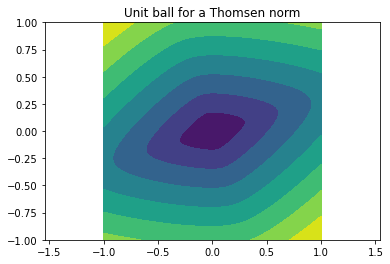

In [16]:
value = th.ThomsenData['Muscovite crystal']
tti   = Seismic.TTI.from_Thomsen(value)[0].extract_xz().rotate_by(0.3)
hooke = Seismic.Hooke.from_Thomsen(value)[0].extract_xz().rotate_by(0.3)

assert np.allclose(tti.norm(X),hooke.norm(X))
plt.title("Unit ball for a Thomsen norm");  plt.axis('equal')
plt.contourf(*X,hooke.norm(X));

The TTI norm and Hooke tensor norm defined from these models coincide up to machine precision.

In [17]:
tested = list(th.ThomsenData.items())[:3]
for key,value in tested:
    value = xp.asarray(value)
    tti   = Seismic.TTI.from_Thomsen(value)[0].extract_xz()
    hooke = Seismic.Hooke.from_Thomsen(value)[0].extract_xz()
    
    assert np.allclose(tti.norm(X),hooke.norm(X),atol=1e-5) # atol for float32

### 1.4 Taking into account the topography

We reproduce a numerical experiment presented in the notebook [Seismic.ipynb], where the metric is constant, but the domain is a diffeomorphically mapped rectangle.

In [18]:
def h(x,z,alpha=0.5): return ad.array([x, z + alpha*z*np.sin(np.pi*x)])

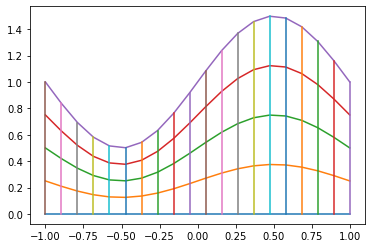

In [19]:
X = np.linspace(-1,1,20)
Z = np.linspace(0,1,5)
for z in Z: plt.plot(*h(X,z)) 
for x in X: plt.plot(*h(x+0.*Z,Z))

In [20]:
hfmIn = Eikonal.dictIn({
    'model':'TTI2',
    'exportValues':1,
    'seed':[0.,0.5],
})

# Define the domain
hfmIn.SetRect(sides=[[-1,1],[0,1]],dimx=101)
hfmIn.SetUniformTips((6,6))

X0 = hfmIn.Grid() # Grid coordinates (horizontal and vertical)
X = h(*X0) # Physical coordinates

By default, for the GPU eikonal solver, the TTI norm is obtained as the envelope of $7$ Riemannian norms. This turns out to be insufficient for the strongly anisotropic crystal chosen here. We change below this value to $15$, in order to have better behaved geodesics. (The CPU eikonal solver uses a different formulation, and has no such restriction.)

In [21]:
if hfmIn.mode=='gpu':hfmIn['traits']={'nmix_macro':15}

In [22]:
X0_ad = ad.Dense.identity(constant=X0,shape_free=(2,))
Jac = h(*X0_ad).gradient().swapaxes(0,1)

In [23]:
hfmIn['metric'] = mica.extract_xz().rotate_by(-np.pi/6).inv_transform(Jac) 

In [24]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.055014 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


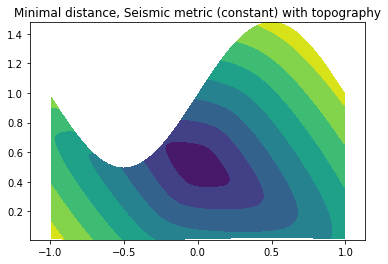

In [25]:
fig = plt.figure(figsize=[6,4]); plt.axis('equal');
plt.title('Minimal distance, Seismic metric (constant) with topography'); 
plt.contourf(*X,hfmOut['values']);

The geodesics are expected to be straight lines, except for the ones tangent to the topography.

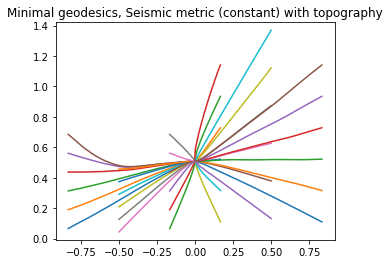

In [26]:
fig = plt.figure(figsize=[5,4]);  plt.axis('equal'); 
plt.title('Minimal geodesics, Seismic metric (constant) with topography');
for geo in hfmOut['geodesics']:  plt.plot(*h(*geo)) 

Note that the computation involved a rather strongly anisotropic and non-constant metric, on a rectangle.

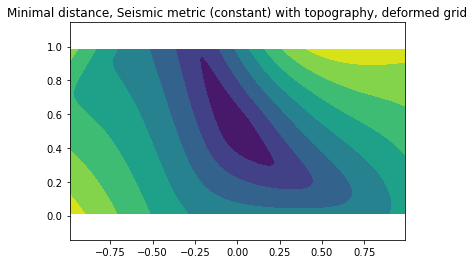

In [27]:
plt.title('Minimal distance, Seismic metric (constant) with topography, deformed grid'); plt.axis('equal')
plt.contourf(*X0,hfmOut['values']);

## 2 Three dimensions

### 2.1 Constant metric

In [28]:
hfmIn_Constant = Eikonal.dictIn({
    'model':'TTI3',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':[[0.,0.,0.]],
    'factoringRadius':20,
    'seedRadius':2,
#    'order':2
#    'exportGeodesicFlow':1,
})

hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1],[-1,1] ],dimx=31,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() 

metric = Seismic.TTI([1.,1],[[0.5,0.1],[0.1,-0.2]],vdim=3).rotate_by(0.5,axis=(1,2,3))
hfmIn_Constant['metric'] = metric

In [29]:
hfmOut = hfmIn_Constant.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.445018 s.


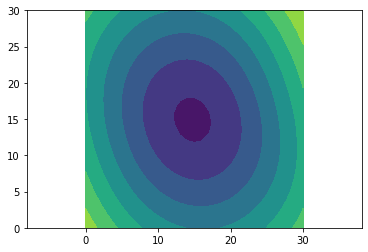

In [30]:
plt.axis('equal')
plt.contourf(hfmOut['values'][:,5,:]);

The largest difference between the exact value and the fast marching result is in the corners, because several of the stencil points may be outside the domain.

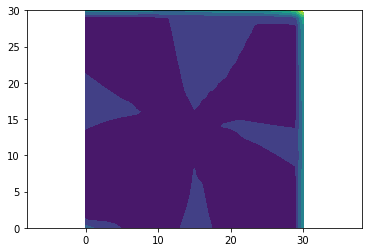

In [31]:
plt.axis('equal')
plt.contourf(hfmOut['values'][:,5,:]-metric.norm(X)[:,5,:]);

In [32]:
assert norm_infinity(hfmOut['values'] - metric.norm(X)) < 2e-2

### 2.2 Varying metric

In [33]:
hfmIn = Eikonal.dictIn({
    'model':'TTI3', 
    'exportValues':1,
    'seed':[0.,0.,0.5],
    'factoringRadius':7,
    'order':2
})

# Define the domain
n=30; 
hfmIn.SetRect(sides=[[-1,1],[-1,1],[0,1]],dimx=n)

In [34]:
X,Y,Z = hfmIn.Grid()

In [35]:
rotation1 = lp.rotation( (np.pi/6)*np.sin(2*np.pi*(X+0.4)), (1,0,0))
rotation2 = lp.rotation( (np.pi/6)*np.sin(2*np.pi*(Y-0.7)), (0,1,0))
rotation = lp.dot_AA(rotation1,rotation2)

hfmIn['metric'] = mica.rotate(rotation)

In [36]:
if hfmIn.mode=='gpu':hfmIn['traits']={'nmix_macro':10}

In [37]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.912811 s.


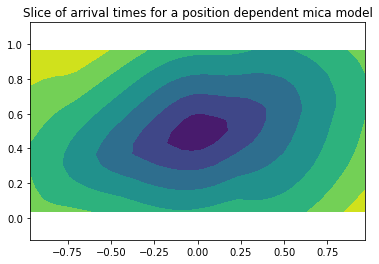

In [38]:
nHalf=n//2
plt.axis('equal'); plt.title('Slice of arrival times for a position dependent mica model')
plt.contourf(Y[nHalf,:,:],Z[nHalf,:,:],hfmOut['values'][nHalf,:,:]);

## 3 Building a model from an array of Thomsen parameters

We discuss in slightly more detail the manipulation of Thomsen parameters, see "Weak elastic anisotropy" (Thomsen, 1986).

In Thomsen's notation, an elastic material is specified via six parameters: 
$$
    (V_p,V_s,\epsilon,\eta,\delta,\gamma,\rho).
$$
- $V_p$ and $V_s$ are measured in m/s, and related to the velocity of pressure and shear waves.
- $\epsilon,\eta,\delta,\gamma$ are dimensionless parameters, specifiying the shape of the anisotropy.
- $\rho$ measured in g/cm^3, is the material density.

In [39]:
tem = th.ThomsenData['Muscovite crystal']
tem

ThomsenElasticMaterial(Vp=4420, Vs=2091, ε=1.12, η=-1.23, δ=-0.235, γ=2.28, ρ=2.79)

**Note on the fieldname $\epsilon$.**
At the time of writing, the `namedtuple` fields must be normalized unicode characters.
This is why the 'ε' is used instead of 'ϵ' as a fieldname in `ThomsenElasticMaterial`.
See https://stackoverflow.com/a/30505623/12508258 for more discussion.

In [40]:
import unicodedata; assert 'ε' == unicodedata.normalize('NFKC','ϵ')

### 3.1 Hexagonal materials and Thomsen's parameter $\delta$ 

Thomsen parameters can be converted into the (reduced) Hooke tensor coefficients of a material with hexagonal symmetry.
This step is done implicitly when producing `Seismic.TTI` or `Seismic.Hooke` objects which can be handled by the eikonal solvers.

In [41]:
hexa,ρ = th.HexagonalFromTEM(tem)
print("Hooke tensor coefficients :", hexa)
print("Density :",ρ)

Hooke tensor coefficients : HexagonalMaterial(c11=63297936.00000001, c12=14678171.280000009, c13=6828108.80578232, c33=19536400, c44=4372281)
Density : 2.79


Recall that the *reduced* Hooke tensor is measured in $m^2/s^2$, and already incorporates the speed modulation due to density. Some coefficients have particularly simple expressions.

In [42]:
assert np.allclose(hexa.c33,tem.Vp**2)
assert np.allclose(hexa.c44,tem.Vs**2)

The parameter $\delta$ is ignored in this conversion.

In [43]:
tem_δnan = th.ThomsenElasticMaterial(tem.Vp, tem.Vs, tem.ε, tem.η, np.nan, tem.γ, tem.ρ)
assert th.HexagonalFromTEM(tem_δnan) == th.HexagonalFromTEM(tem)


Indeed, Thomsen parameters are *not* independent, and the parameter $\delta$ is defined as 
$$
    2 \delta = \epsilon + \frac \eta {1-V_s^2/V_p^2}.
$$
The `get_δ` function implements this formula.

In [44]:
print("Thomsen original data : δ =",tem[4])
print("Reconstructed : δ =", th.get_δ(*tem[:4]))

Thomsen original data : δ = -0.235
Reconstructed : δ = -0.23232337862819452


Unfortunately Thomsen's own published data seems inconsistent in this regard. *Or maybe I missed something ?*

In [45]:
consistent,factor_two,weird = {},{},{}
for name,tem in th.ThomsenData.items():
    δ_ratio = tem.δ/ th.get_δ(*tem[:4]) # Published data / Reconstructed data
    if abs(δ_ratio-1)<0.1:   consistent[name] = δ_ratio
    elif abs(δ_ratio-2)<0.1: factor_two[name] = δ_ratio
    else:                    weird[name] = δ_ratio
        
print("Consistent published and reconstructed δ :",len(consistent),"cases")
print("Factor two omitted :",len(factor_two),"cases")
print("Unexplained :",weird)

Consistent published and reconstructed δ : 34 cases
Factor two omitted : 11 cases
Unexplained : {'Mesaverde (5837.5) immature sandstone': 1.6391370492618653, 'Mesaverde shale (1599)': 2.198347682314651, 'Mesaverde shale (1968)': 1.8155430928298144, 'Mesaverde shale (3511)': -0.0, 'Lance sandstone': 0.5510408013430982, 'Ft. Union siltstone': 1.3518799584691759, 'Timber Mtn tuff': -3.639828155038852, 'Sandstone-shale': 1.5040028850050553, 'SS-anisotropic shale': 1.6876274645369542, 'Limestone-shale': -0.0, 'LS-anisotropic shale': -0.0, 'Anisotropic shale': 1.2866379663485796, 'Gas sand-water sand': 1.8832132129622101}


### 3.2 A numerical example, with the TTI eikonal solver

We compute traveltimes in a two dimensional test case, that is made of two different materials.

In [46]:
n=50
hfmIn = Eikonal.dictIn({
    'model':'TTI2',
    'exportValues':1,
    'seed':[0.2,0.2],
    'factoringRadius':-1, 
    'order':1
})
hfmIn.SetRect(sides=[[0,2],[0,1]],dimx=2*n,sampleBoundary=True) # Define the domain
hfmIn.SetUniformTips([4,2])
X,Z = hfmIn.Grid() # Horizontal and vertical axis

In some use cases, the material may be specified as 
- an array of thomsen parameters
- an array of angles specifying the tilt. (In three dimensions, an additional axis must be specified, or alternatively the full rotation matrix.)

For illustration, we consider a piecewise constant material.

**Note on the scheme order.**
High order accuracy can only be achieved with smooth data. In the case of a piecewise constant material, using the second order scheme may do more harm than good, depending on the case.

In [47]:
top = Z >= 1.2-X/2

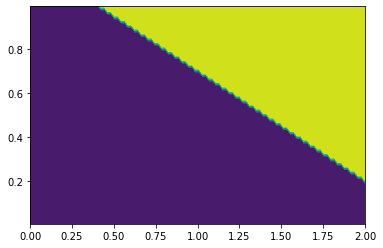

In [48]:
plt.contourf(X,Z,top);

In [49]:
θ = xp.where(top,np.pi/6,-np.pi/4)
def broadcast(tem): return xp.array(tem)[:,None,None]
tem = np.where(top, broadcast(th.ThomsenData['Ice I crystal']), broadcast(th.ThomsenData['Muscovite crystal']) )

In [50]:
# Produce the TTI geometry and density from the material data.
vti,ρ = Seismic.TTI.from_Thomsen(tem) 
# Slice in two dimensions, and rotate by chosen tilt.
hfmIn['metric'] = vti.extract_xz().rotate_by(θ)

In [51]:
if hfmIn.mode=='gpu':hfmIn['traits']={'nmix_macro':15}

In [52]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.029231 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


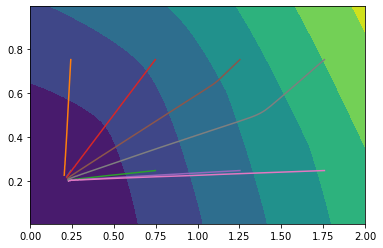

In [53]:
plt.contourf(X,Z,hfmOut['values']);
for geo in hfmOut['geodesics']: plt.plot(*geo)

### 3.3 Using the Hooke eikonal solver

Similar results can be obtained using the eikonal solver based on Hooke tensors.

In [54]:
if xp is not np: raise ad.DeliberateNotebookError("Hooke eikonal solver is not implemented on the gpu")

In [55]:
hfmIn['model']='Seismic2'
# Produce the TTI geometry and density from the material data.
vti,ρ = Seismic.Hooke.from_Thomsen(tem) 
# Slice in two dimensions, and rotate by chosen tilt.
hfmIn['metric'] = vti.extract_xz().rotate_by(θ)

In [56]:
hfmOut = hfmIn.Run()

Field verbosity defaults to 1
Field cosAngleMin defaults to 0.5
Field seedRadius defaults to 2
Field factoringPointChoice defaults to Seed
Field exportFactoring defaults to 0
Fast marching solver completed in 0.025531 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45


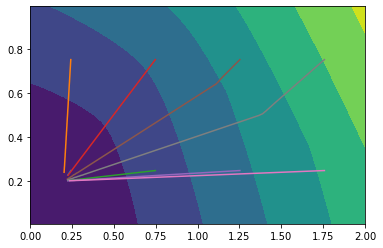

In [57]:
plt.contourf(X,Z,hfmOut['values']);
for geo in hfmOut['geodesics']: plt.plot(*geo)